# IMDB 데이터셋

## 개요
IMDB 데이터셋은 주로 영화 리뷰와 관련 정보를 포함하며, 각 리뷰는 긍정적 또는 부정적인 감정 레이블을 가지고 있어 감정 분석 모델의 훈련에 이용됩니다. 주로 사용되는 'IMDB Movie Reviews' 데이터셋은 50,000개의 리뷰로 구성되어 있습니다. (단, 리뷰는 모두 영어로 구성되어있음)

(링크: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

## 구성
- 훈련 데이터: 25,000개의 리뷰
- 테스트 데이터: 25,000개의 리뷰
- 포맷: 각 리뷰는 레이블이 지정된 텍스트 파일 형태
- 감정 레이블: 긍정 (1), 부정 (0)
- 리뷰 길이: 다양하지만, 평균적으로는 몇 백 단어 내외

### 1. IMDB 데이터 불러오기 및 전처리 데이터 불러오기 (전처리 포함)

- max_features = 10000: 모델이 처리할 최대 단어 수입니다.

- maxlen = 500: 각 리뷰의 최대 길이를 500으로 설정합니다. 이보다 긴 데이터는 자르고, 짧은 데이터는 패딩합니다.

- imdb.load_data(num_words=max_features): IMDB 데이터셋을 로드합니다. 여기서 num_words=max_features는 데이터셋에서 가장 빈번한 10,000개의 단어만 사용하겠다는 의미입니다.

- sequence.pad_sequences(...): 리뷰의 길이를 maxlen으로 맞추기 위해 짧은 데이터는 0으로 채웁니다 (패딩).

In [1]:
# 필요 라이브러리 import
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

# 데이터 파라미터 설정
max_features = 10000

# 데이터 불러오기
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=max_features)

# 데이터 개수 확인
for i in range(10):
    print(len(X_train[i]))


17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
218
189
141
550
147
43
123
562
233
130


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


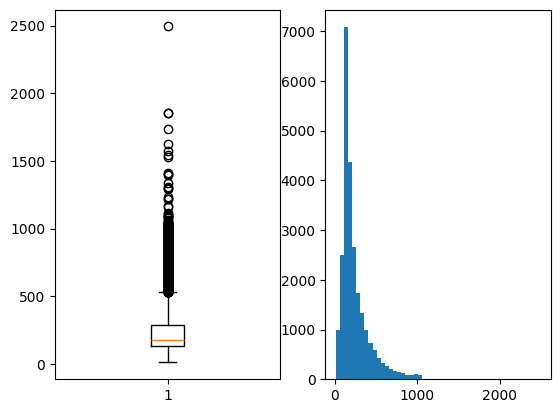

In [2]:
# 리뷰의 최대 길이, 평균길이 확인
import matplotlib.pyplot as plt
import numpy as np

len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [5]:
# 시퀀스 길이 계산
lengths = []
# X_train의 각 행에 접근
for x in X_train:
    # 현재 요소 X의 길이를 구함
    length = len(x)
    # X의 길이를 리스트에 추가
    lengths.append(length)

# 최대값을 기준으로 길이 결정
maxlen = max(lengths)
print('max:', maxlen)

# 95%의 데이터를 포함하는 길이 결정
maxlen = int(np.percentile(lengths, 95))
print('95%:', maxlen)

# 데이터 패딩 (짧은 데이터는 0으로 채우고, 긴 데이터는 잘라내어, 데이터가 maxlen개로 유지되도록 한다)
X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)

max: 2494
95%: 610


In [10]:
# 데이터 확인
# print(X_train[5])

# 변경된 데이터 구조 확인
for i in range(10):
    print(len(X_train[i]))

610
610
610
610
610
610
610
610
610
610


### 2. 모델 생성하기

- Sequential(): 층을 선형으로 쌓는 모델을 생성합니다.

- Embedding(max_features, 32, input_length=maxlen): 단어 임베딩 층을 추가합니다. 여기서 max_features는 입력 차원(단어의 개수), 32는 출력 차원(임베딩 벡터의 크기)입니다.

- Flatten(): 임베딩 층의 출력을 1차원 배열로 변환합니다.

- Dense(64, activation='relu'): 64개 뉴런을 가진 완전 연결 층(Dense layer)을 추가합니다. relu는 비선형 활성화 함수입니다.

- Dense(1, activation='sigmoid'): 최종 출력 층. sigmoid 활성화 함수를 사용하여 긍정/부정을 이진 분류합니다.

In [40]:
# 필요 라이브러리 import
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint

# ModelCheckpoint 콜백 생성


# 모델 구성
model = Sequential()
# input_dim : 우리가 임베딩할 전체 단어의 개수(우리가 데이터셋을 불러올 때 = 지정한 총 단어수)
# output_dim : 단어를 몇 개의 차원(리스트 개수)으로 표현할 것인가
# input_length : 한 번에 몇 개의 단어를 학습할 것인가(일반적으로 우리가 설정해놓은 단어수(maxlen)로 결정
model.add(Embedding(input_dim=max_features, output_dim=128, input_length=maxlen))
model.add(SimpleRNN(128))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) # 긍정/부정의 이진 분류

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### 3. 모델 컴파일하기

- model.compile(...): 모델을 컴파일합니다.
  - adam 최적화기를 사용하고, binary_crossentropy 손실 함수를 적용합니다. 정확도(accuracy)를 기준으로 평가합니다.

In [33]:
# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 4. 모델 학습하기

- model.fit(...): 모델을 학습시킵니다.
  - 여기서 epochs=5는 전체 데이터셋을 5번 반복하여 학습하고, batch_size=128은 한 번에 128개의 샘플을 처리합니다.
- validation_split=0.2는 학습 데이터의 20%를 검증 데이터로 사용합니다.

In [34]:
# 모델 학습
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 176ms/step - accuracy: 0.5521 - loss: 0.6840 - val_accuracy: 0.8000 - val_loss: 0.4517
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step - accuracy: 0.8186 - loss: 0.4072 - val_accuracy: 0.7462 - val_loss: 0.5099
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step - accuracy: 0.9204 - loss: 0.2202 - val_accuracy: 0.8132 - val_loss: 0.4663
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.9677 - loss: 0.0976 - val_accuracy: 0.7962 - val_loss: 0.5536
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.9898 - loss: 0.0367 - val_accuracy: 0.7802 - val_loss: 0.7194
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 0.9952 - loss: 0.0209 - val_accuracy: 0.8160 - val_loss: 0.6963
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 171ms/step - accuracy: 0.9984 - loss: 0.0074 - val_accuracy: 0.7886 - val_loss: 0.8060
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 172ms/step - accuracy: 1.0000 - loss: 0

### 5. 모델 평가하기

- classification_report(...): sklearn 라이브러리의 함수를 사용하여 모델의 성능을 평가합니다.

- sigmoid함수를 사용했으므로 예측값의 0.5 이상인 경우는 1로 변환합니다.

In [18]:
# 모델 평가
from sklearn.metrics import classification_report

# 실제 라벨과 예측 라벨
actual = y_test
predicted = model.predict(X_test)
predicted_labels = (predicted > 0.5).astype(int)

# classification_report 출력
report = classification_report(actual, predicted_labels, target_names=['Positive', 'Negative'])
print(report)

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step
              precision    recall  f1-score   support

    Positive       0.66      0.72      0.69     12500
    Negative       0.69      0.64      0.66     12500

    accuracy                           0.68     25000
   macro avg       0.68      0.68      0.68     25000
weighted avg       0.68      0.68      0.68     25000



### 6. 추론 결과 시각화

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sample 1 Text: me if i'm wrong that hollywood turned out the best product i've come to learn how sadly naive and i was and 2 how much more sophisticated european asian cinema is in comparison to its american counterpart br br i watched this allegedly disturbing psychological thriller the night following a viewing of a japanese movie called suicide club as the camera faded on walter happy little family enjoying some quality time around a prison visiting room table not to mention the voice over the virtue of doing the right thing i suddenly had an i had just finished watching a movie that left me feeling as though i'd just had a glass of water when i really wanted a beer my was but it was strictly the premise was mildly interesting but the story itself with its how do we explain her finding the book we'll just say something like or did the book find her they'll buy that plot holes why did take the pred

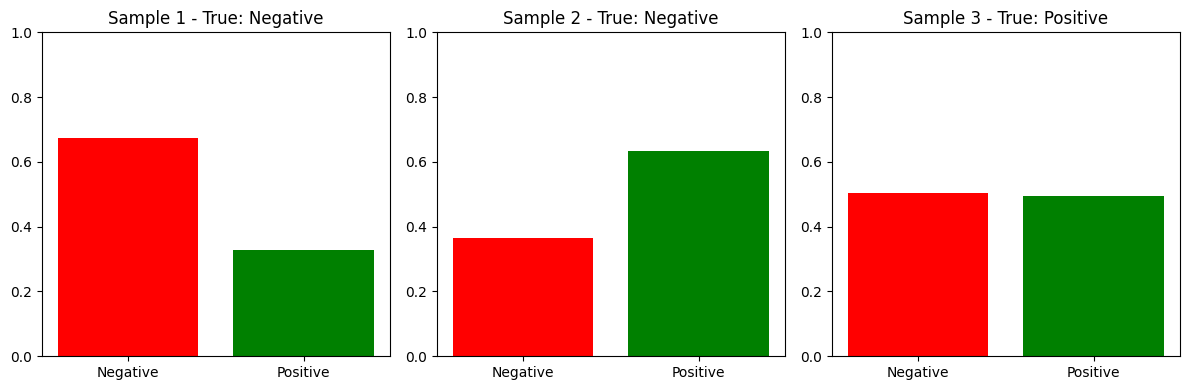

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# 단어 인덱스 로드 및 디코딩을 위한 사전 준비
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# 테스트 데이터에서 샘플 추출
indices = np.random.randint(0, len(X_test), size=3)
samples = X_test[indices]
predictions = model.predict(samples)
true_labels = y_test[indices]

# 샘플 텍스트 디코딩 함수
def decode_review(encoded_review):
    # 오프셋을 고려하여 단어를 가져오되, 매핑되지 않은 인덱스는 '?'로 표시
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review if i > 3])

# 시각화 및 텍스트 출력
plt.figure(figsize=(12, 4))
for i, (sample, prediction, label) in enumerate(zip(samples, predictions, true_labels)):
    plt.subplot(1, 3, i+1)
    plt.bar(['Negative', 'Positive'], [1-prediction[0], prediction[0]], color=['red', 'green'])
    plt.ylim(0, 1)
    plt.title(f'Sample {i+1} - True: {"Positive" if label else "Negative"}')

    # 디코딩된 샘플 텍스트 출력
    decoded_text = decode_review(sample)
    print(f'Sample {i+1} Text: {decoded_text}')

plt.tight_layout()
plt.show()

In [23]:
word_to_index = imdb.get_word_index()
word_to_index

{'fawn': 34701,
 'tsukino': 52006,
 'nunnery': 52007,
 'sonja': 16816,
 'vani': 63951,
 'woods': 1408,
 'spiders': 16115,
 'hanging': 2345,
 'woody': 2289,
 'trawling': 52008,
 "hold's": 52009,
 'comically': 11307,
 'localized': 40830,
 'disobeying': 30568,
 "'royale": 52010,
 "harpo's": 40831,
 'canet': 52011,
 'aileen': 19313,
 'acurately': 52012,
 "diplomat's": 52013,
 'rickman': 25242,
 'arranged': 6746,
 'rumbustious': 52014,
 'familiarness': 52015,
 "spider'": 52016,
 'hahahah': 68804,
 "wood'": 52017,
 'transvestism': 40833,
 "hangin'": 34702,
 'bringing': 2338,
 'seamier': 40834,
 'wooded': 34703,
 'bravora': 52018,
 'grueling': 16817,
 'wooden': 1636,
 'wednesday': 16818,
 "'prix": 52019,
 'altagracia': 34704,
 'circuitry': 52020,
 'crotch': 11585,
 'busybody': 57766,
 "tart'n'tangy": 52021,
 'burgade': 14129,
 'thrace': 52023,
 "tom's": 11038,
 'snuggles': 52025,
 'francesco': 29114,
 'complainers': 52027,
 'templarios': 52125,
 '272': 40835,
 '273': 52028,
 'zaniacs': 52130,

### 7. 결과 테스트

In [24]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
word_to_index = imdb.get_word_index()

def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()

  # 정수 인코딩
  encoded = []
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 max_features으로 제한.
      if word_to_index[word] <= max_features:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=maxlen) # 패딩
  score = float(model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [25]:
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
57.01% 확률로 부정 리뷰입니다.


C:\Users\qq\AppData\Local\Temp\ipykernel_2364\3867352607.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(pad_sequence)) # 예측


In [26]:
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
80.32% 확률로 긍정 리뷰입니다.


C:\Users\qq\AppData\Local\Temp\ipykernel_2364\3867352607.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(model.predict(pad_sequence)) # 예측


In [ ]:
# 긍정 리뷰를 작성해서 테스트 해보세요,

In [ ]:
# 부정 리뷰를 작성해서 테스트 해보세요.